Muon constants <br>
https://pdglive.lbl.gov/Particle.action?node=S004&init=0

# Theory of Muon Magnetic Moment Determination

## Experimental Setup

**Components:**
- **Cosmic Ray Muons:** Source particles from atmospheric interactions
- **Trigger Detector:** Identifies muon arrival
- **Solenoid:** Generates uniform magnetic field (B ≈ 5.6 mT)
- **Absorber:** Dense material block where muons decay
- **Positron Detector:** Detects decay products

## Physics Principles

### Without Magnetic Field
Simple exponential decay:
$$N(t) = N_0 e^{-t/\tau_\mu}$$

Muon lifetime: $\tau_\mu = 2.1969811 \pm 0.0000022$ μs

### With Magnetic Field
Muon spin precesses with frequency:
$$\omega = g_\mu \frac{eB}{2m_\mu c}$$

Time-dependent signal with oscillation:
$$N(t) = N_0 e^{-t/\tau_\mu}[1 + A \cos(\omega t + \phi)]$$

### Decay Process
$$\mu^+ \rightarrow e^+ + \nu_e + \bar{\nu}_\mu$$
$$\mu^- \rightarrow e^- + \bar{\nu}_e + \nu_\mu$$

## Analysis Method
**MCMC fitting:**
- **B = 0:** Extract $\tau_\mu$ from exponential decay
- **B ≠ 0:** Extract $\omega$ from oscillating signal
- Determine $g_\mu$ from measured precession frequency

# SIMULATED DATA

In [1]:
G.mean  <- 2.00233184123 # pure number
G.sigma <- 0.00000000014 # pure number

TAU.mean  <- 2.1969811  # microseconds
TAU.sigma <- 0.0000022  # microseconds

B.mean  <- 5.6e-3  # Tesla
B.sigma <- 0.1e-3  # Tesla

MASS.mean  <- 105.6583755e6 # ev/c^2
MASS.sigma <-   0.0000023e6 # Mv/c^2

c <- 299792458 # m/s
e <- 1.60217663e-19 # Coulomb

MASS.kg <- MASS.mean*e / c^2  # kg

OMEGA <- ((G.mean*e*B.mean) / (2*MASS.kg)) / 1e6  # MHz

cat("Omega is: ",OMEGA,"MHz. \n")

Omega is:  4.769047 MHz. 


In [2]:
N0  <- 1e3 # number initial muons
A   <- 0.02 # % polarized muons
phi <- -1   # initial phase

In [3]:
dt <- 0.05
t <- seq(dt/2, 15, dt) # microseconds
#Effeciency.Detector <- 0.8 # to introduce randomness even in the time component
#mask <- sample(c(TRUE, FALSE), size=length(t), replace=TRUE, prob=c(Effeciency.Detector,1-Effeciency.Detector))
#t <- t[mask]

N.noB.ideal <- N0 * exp(-t/TAU.mean)

N.withB.ideal <- N0 * exp(-t/TAU.mean) * (1 + A*cos(OMEGA*t+phi))

GenerateData <- function(t, N.ideal, show=FALSE) {

    set.seed(as.integer((as.numeric(Sys.time()) %% 1) * 1e8)) #uso il tempo del pc per generare un numero casuale

    sigma <- sqrt( N.ideal * ( 1-N.ideal/sum(N.ideal) ) ) |> round(10)
    sigma <- pmax(sigma,1) |> as.integer()

    # VARI TENTATIVI
    #N <- rpois(length(t), N.ideal) # simulated measurements
    #noise <- rnorm( length(t), mean=0, sd=sqrt(N.ideal) ) # simulated background noise
    #N <- (N + noise)
    #N <- N * runif(length(t),0.8,1.2) |> round(,0) |> as.integer()

    N <- rnorm( length(t),N.ideal, sigma ) |> round(10)
    N <- pmax( N,0 ) |> as.integer()
        
    data <- data.frame(t=t, y=N, s=sigma)
    if (show) { print( head(data,5) ); cat("\n") ; print( tail(data,5) ) ; cat("\n") }

    return(data)
    }

In [4]:
plot.data <- function(data, title) {
    options(repr.plot.width=16,repr.plot.heigth=8)
    
    par(mfrow=c(1,2))
    
    # normal scale
    plot(data$t, data$y, type="p", pch=16, col="red",
         xlab=expression("Time ["*mu*"s]"), ylab="Counts", main=title,
         cex.main=1.5, cex.axis=1.5, cex.lab=1.5)

    arrows(data$t, data$y-data$s, data$t, data$y+data$s,
           angle=90, code=3, length=0.02, col="lightblue")
    
    # log scale
    plot(data$t, pmax(data$y,1), log="y", yaxt="n", type="p", pch=16, col="blue",
         xlab=expression("Time ["*mu*"s]"), ylab="Counts", main=title,
         cex.main=1.5, cex.axis=1.5, cex.lab=1.5)
    
    arrows(data$t, data$y-data$s, data$t, data$y+data$s,
           angle=90, code=3, length=0.02, col="lightblue")

    axis(2, at=10^(0:5), labels=parse(text=paste0("10^", 0:5)), las=1)

    }

In [5]:
data.noB   <- GenerateData(t, N.noB.ideal, show=TRUE)

      t    y  s
1 0.025 1031 31
2 0.075  994 30
3 0.125  970 30
4 0.175  928 30
5 0.225  878 29

         t y s
296 14.775 0 1
297 14.825 0 1
298 14.875 1 1
299 14.925 0 1
300 14.975 0 1



In [6]:
data.withB <- GenerateData(t, N.withB.ideal, show=TRUE)

      t    y  s
1 0.025 1013 31
2 0.075  961 30
3 0.125  887 30
4 0.175  927 30
5 0.225  903 30

         t y s
296 14.775 2 1
297 14.825 0 1
298 14.875 0 1
299 14.925 0 1
300 14.975 0 1



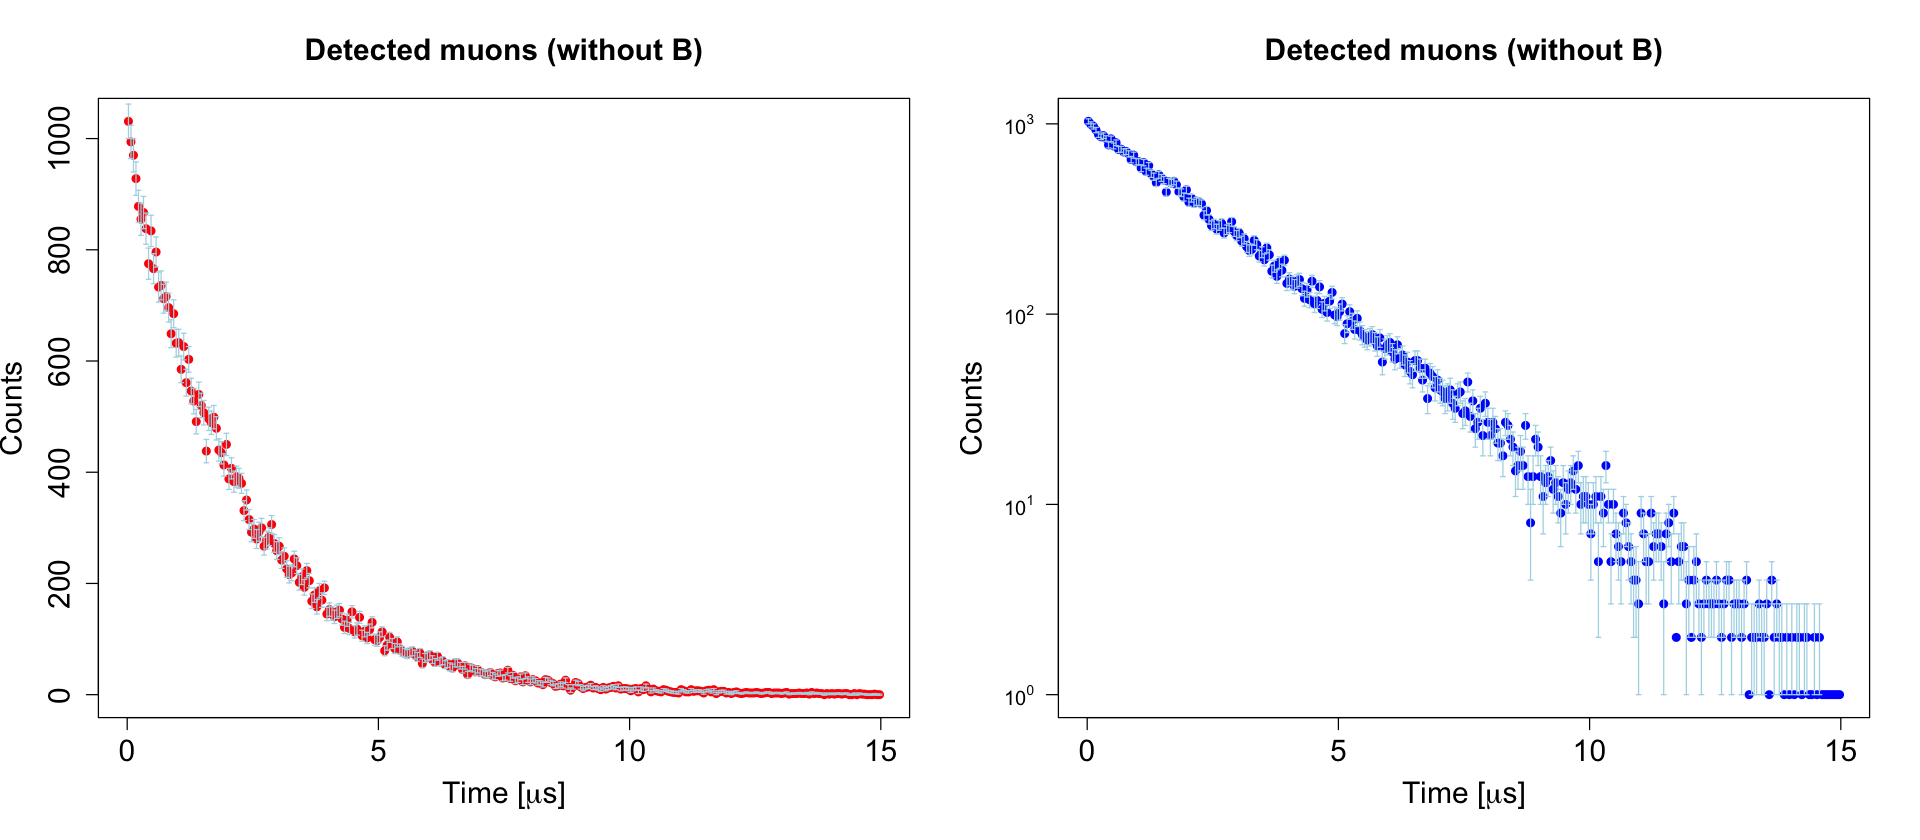

In [7]:
data <- list(data.noB, data.withB)
plot.data(data.noB,"Detected muons (without B)")

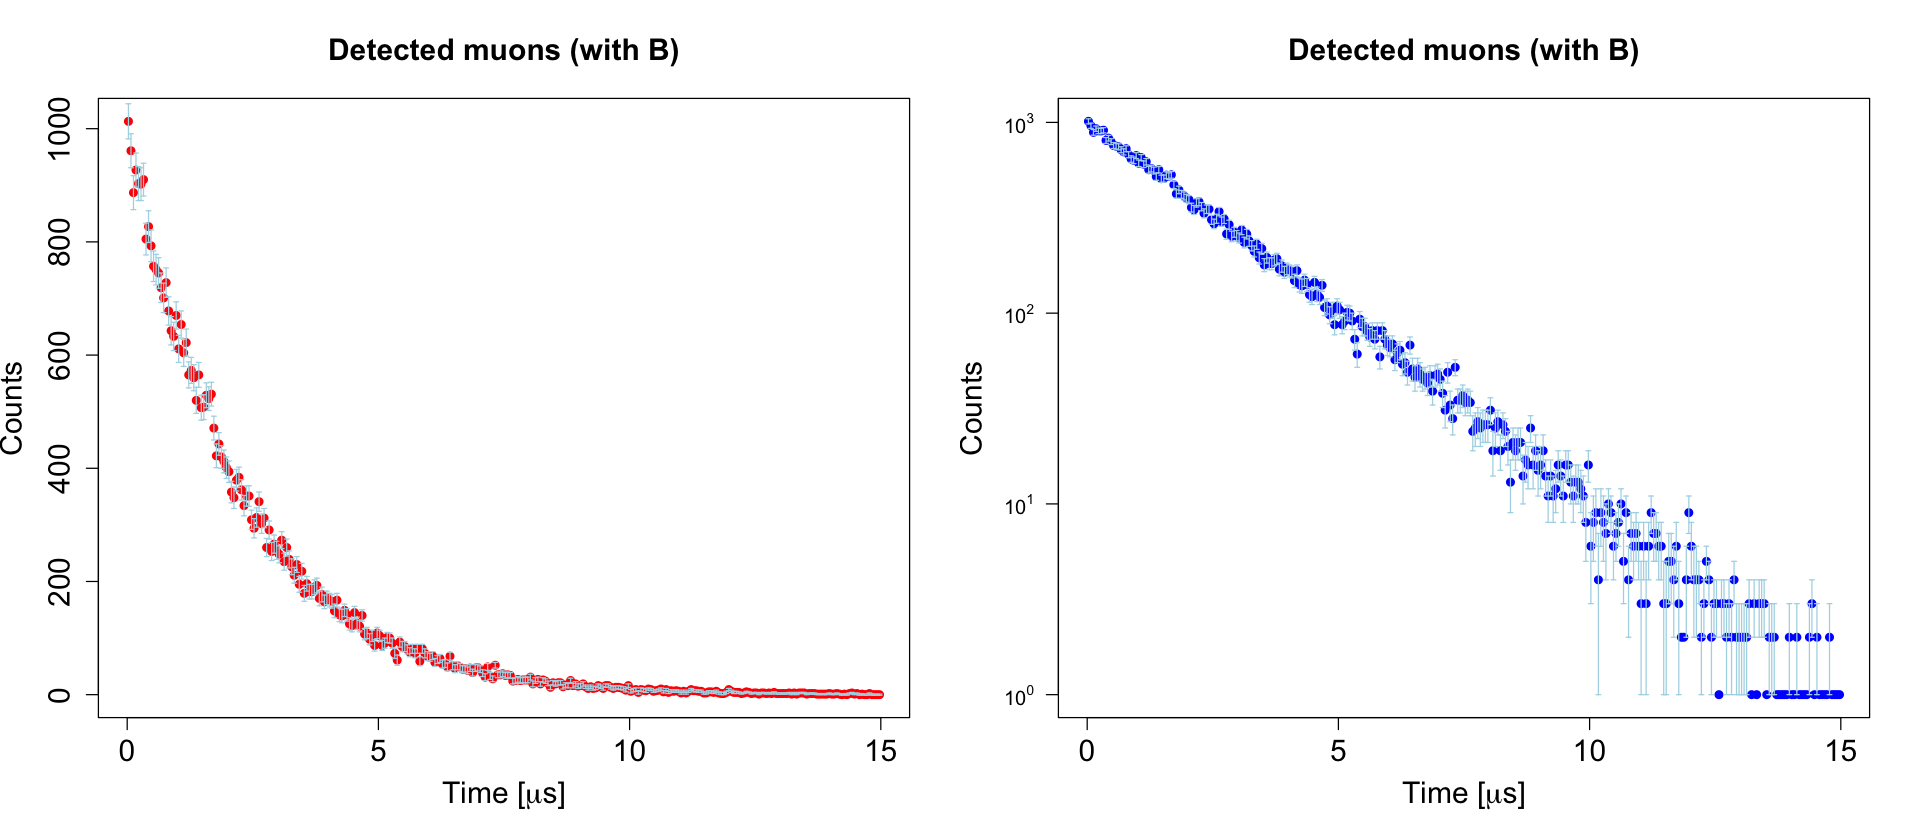

In [8]:
plot.data(data.withB, "Detected muons (with B)")

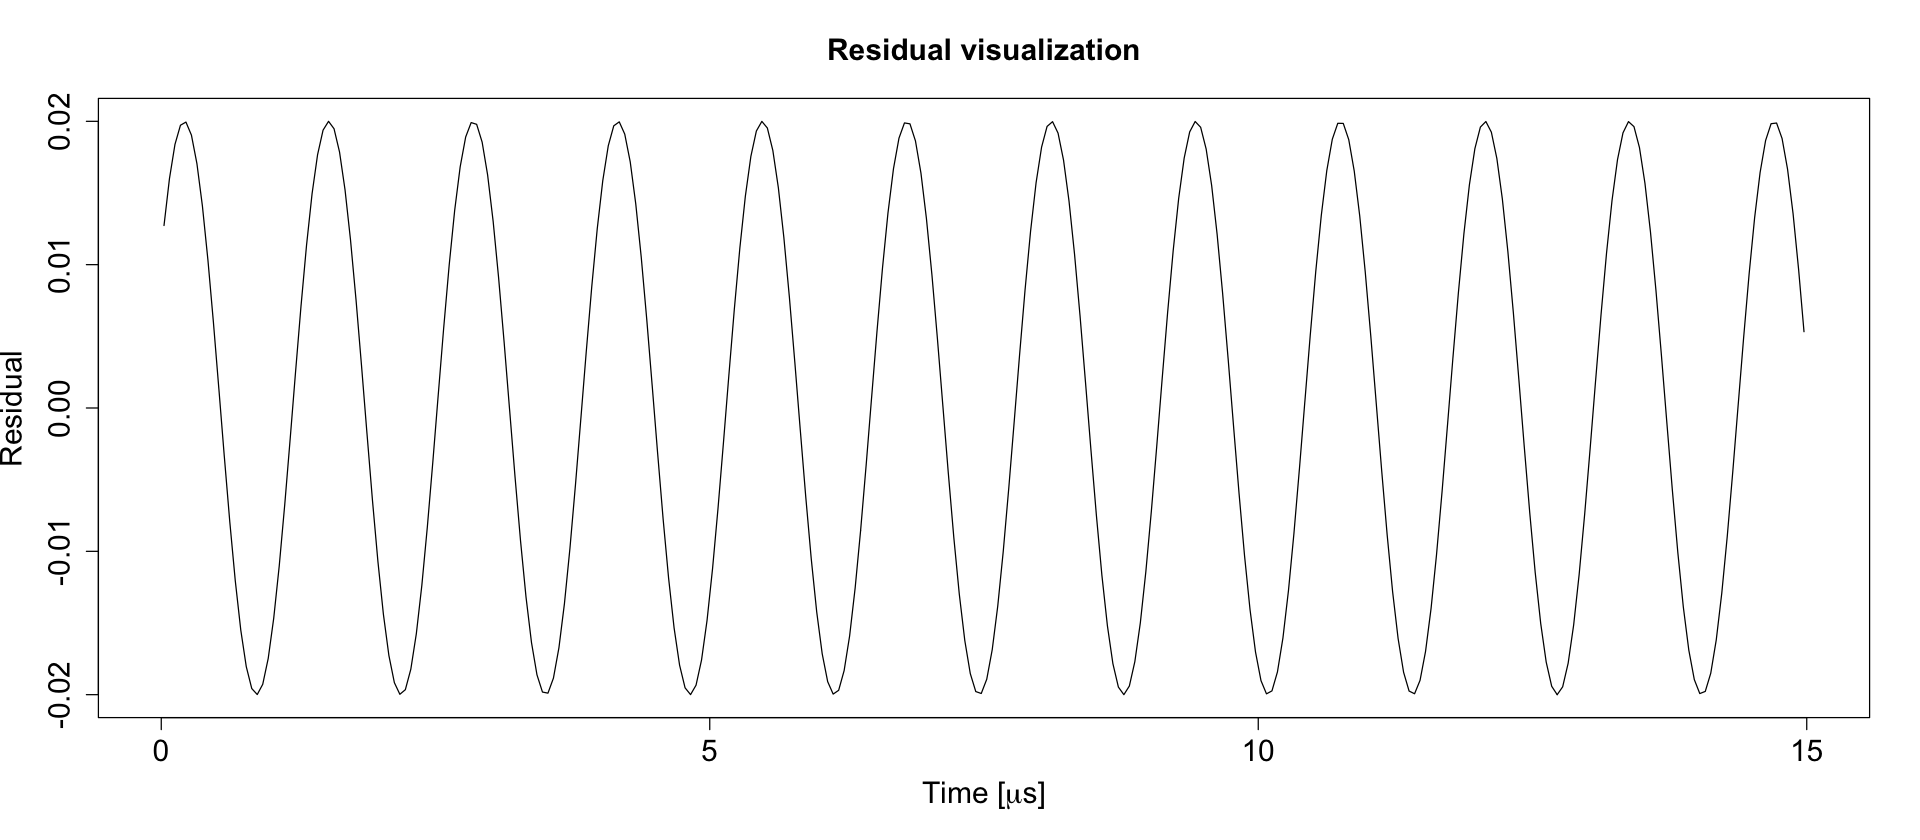

In [9]:
#Plotting the residuals to show the presence of the oscillation:
#Using a different time scale to have a better visualization:

Res <- (N.withB.ideal - N.noB.ideal) / N.noB.ideal

plot(t, Res, type='l', xlab=expression("Time ["*mu*"s]"), ylab="Residual", main='Residual visualization',
         cex.main=1.5, cex.axis=1.5, cex.lab=1.5)

# MCMC ANALYSIS

In [10]:
library("rstan")
options (mc.cores=parallel::detectCores())
rstan_options (auto_write=TRUE)
library("coda")

Loading required package: StanHeaders




rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: 'coda'


The following object is masked from 'package:rstan':

    traceplot




In [ ]:
data.model.stan <- "data {
        int<lower=0> n;
        vector[n] t;
        vector<lower=0>[n] y;
        vector<lower=0>[n] s;
}\n"

parameters <- 
    "parameters {
        real<lower=0> N0;
        real<lower=0> tau;
        real<lower=0, upper=1> A;
        real<lower=0> omega;
        real<lower=0, upper=2*pi()> phi;
    }\n"   

model <- 
   "model {
        N0 ~ normal(y[1],sqrt(y[1])) ;
        tau ~ normal(2.15,0.1) ;
        A ~ uniform(0,0.05) ;
        omega ~ uniform(4.7,4.8) ; 
        phi ~ uniform(0, 2*pi()) ;
        for (i in 1:n) { y[i] ~ normal( N0*exp(-t[i]/tau)*(1+A*cos(2* pi()*omega*t[i]+ phi)), s[i] ); }
    }\n"

In [51]:
# varsatile way, so we can change model since evry time copy & paste

data.model.stan <- "data {
        int<lower=0> n;
        vector[n] t;
        vector<lower=0>[n] y;
        vector<lower=0>[n] s;
}\n"

parameters <- c(
    noB = "parameters {
        real<lower=0> N0;
        real<lower=0> tau;
    }\n",
    withB = "parameters {
        real<lower=0> N0;
        real<lower=0> tau;
        real<lower=0, upper=0.1> A;
        real<lower=4, upper=5> omega;
        real<lower=0, upper=2*pi()> phi;
    }\n"   
)

model <- c(
    noB = "model {
        N0 ~ normal(y[1],sqrt(y[1])) ;
        tau ~ normal(2.2,0.1) ;
        for (i in 1:n) { y[i] ~ normal( N0*exp(-t[i]/tau), s[i] ); }
    }\n",
    withB = "model {
        N0 ~ normal(y[1],sqrt(y[1])) ;
        tau ~ normal(2.15,0.1) ;
        A ~ uniform(0,0.1) ;
        omega ~ normal(4.7, 0.1) ; 
        phi ~ uniform(0, 2*pi()) ;
        for (i in 1:n) { y[i] ~ normal( N0*exp(-t[i]/tau)*(1+A*cos(2*pi()*omega*t[i]+ phi)), s[i] ); }
    }\n"
)


stan.string <- c(noB = paste0(data.model.stan,parameters[1], model[1]), withB = paste0(data.model.stan, parameters[2], model[2]))
#cat( stan.string[[2]] )

#data.stan = c( list( n=length(t), t=data[1]$t, y=data[1]$y, s=data[1]$s ) , list( n=length(t), t=data[2]$t, y=data[2]$y, s=data[2]$s )  )
data.stan = lapply( 1:2, function(i) { list( n=length(t), t=data[[i]]$t, y=data[[i]]$y, s=data[[i]]$s ) } )

In [52]:
analysis.bayes <- function(stan.string, data.stan, which.model) {

   stan <- stan.string[ which.model ]
   data <- data.stan[[which.model]]
   params <- switch( which.model, c("N0","tau") , c("N0","tau","A","omega","phi") )
   stan.model <- stan_model( model_code = stan )

   stan.fit <- sampling(stan.model, data, pars=params, iter=1000, chains=1, warmup=200, thin=1)

   cat( switch( which.model, "WITHOUT B\n" , "WITH B\n" ) )
   print(summary(stan.fit))
   array <- as.array(stan.fit)
   return(array)
}

In [53]:
which.model <- 2
array.mcmc <- analysis.bayes(stan.string, data.stan, which.model=which.model)

# come è fatto array.mcmc[ indice iterazione ,quale catena , parametro:No-tau-omega....]


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 201 / 1000 [ 20%]  (Sampling)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Sampling)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Sampling)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.108 seconds (Warm-up)
Chain 1:                0.409 seconds (Sampling)
Chain 1:                1.517 sec

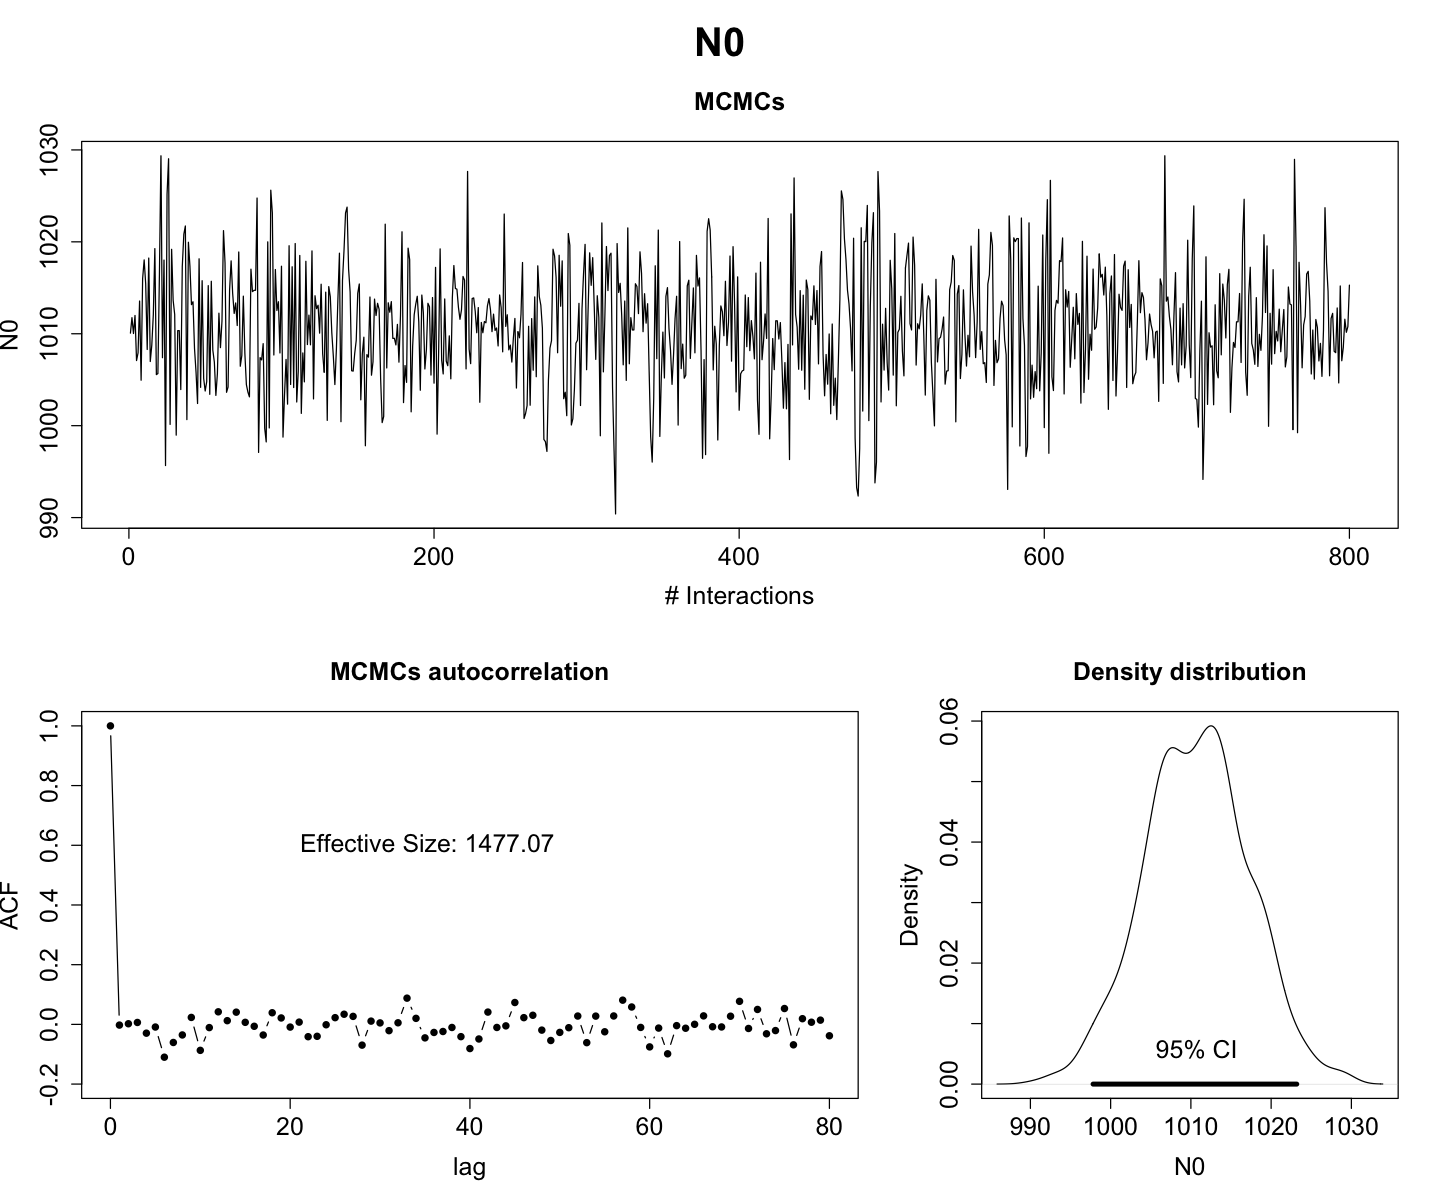

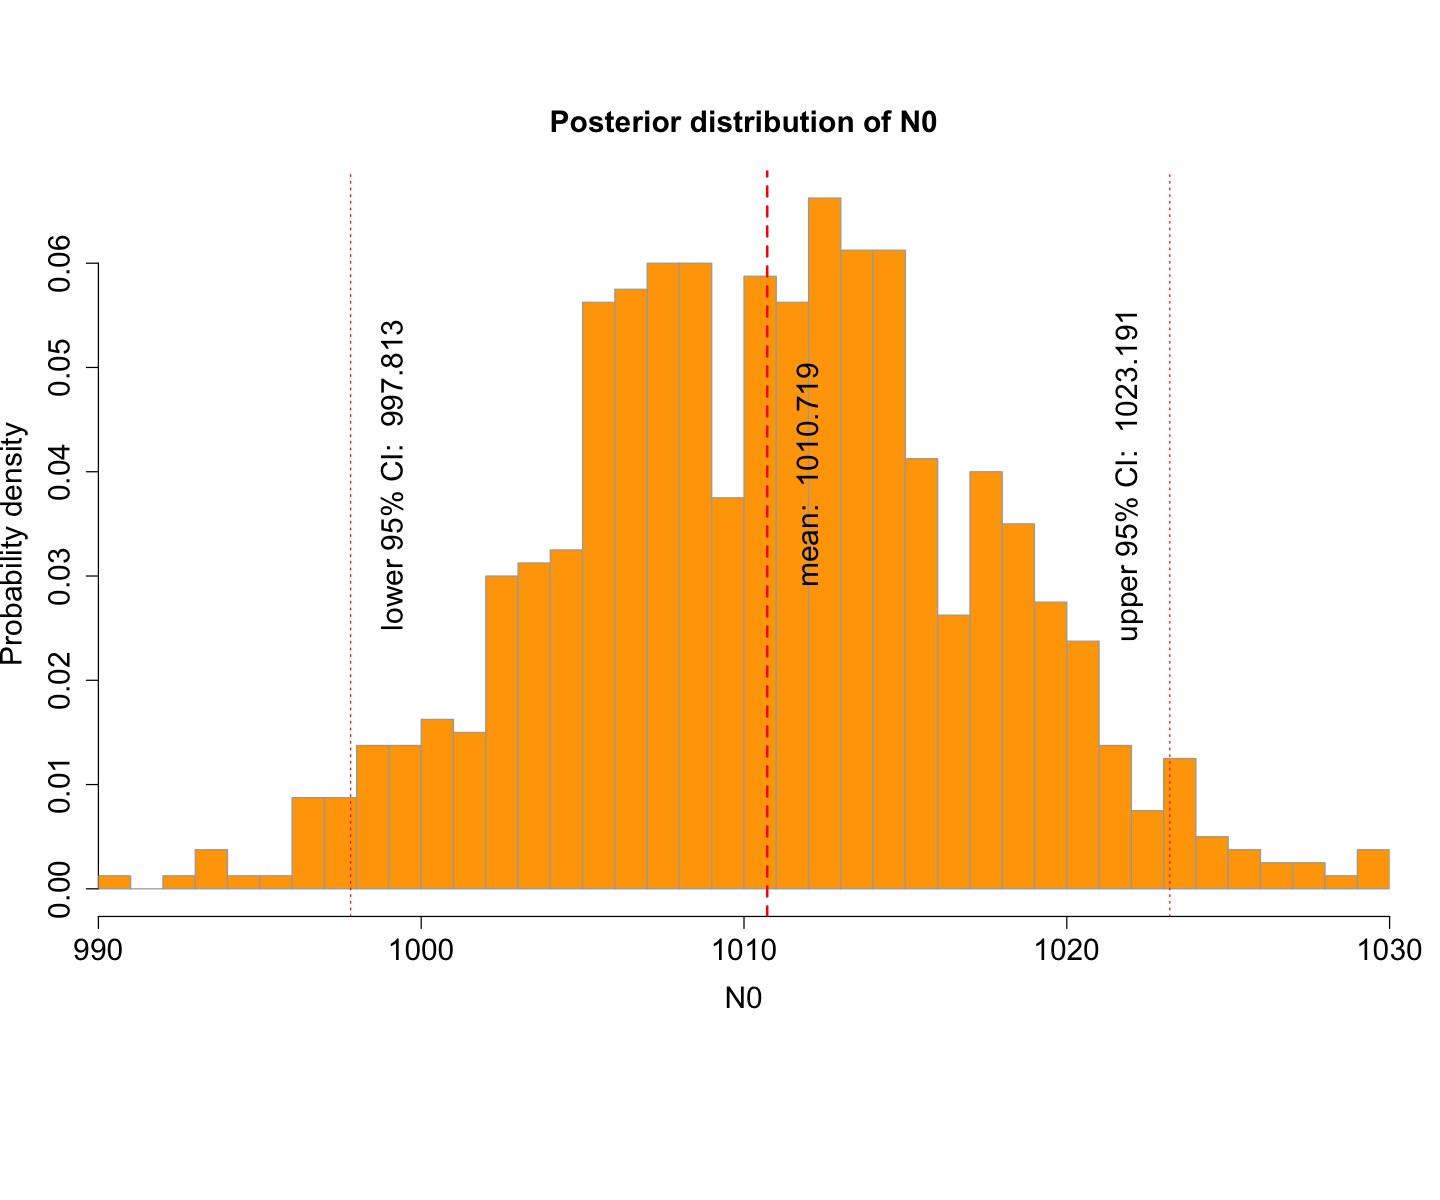

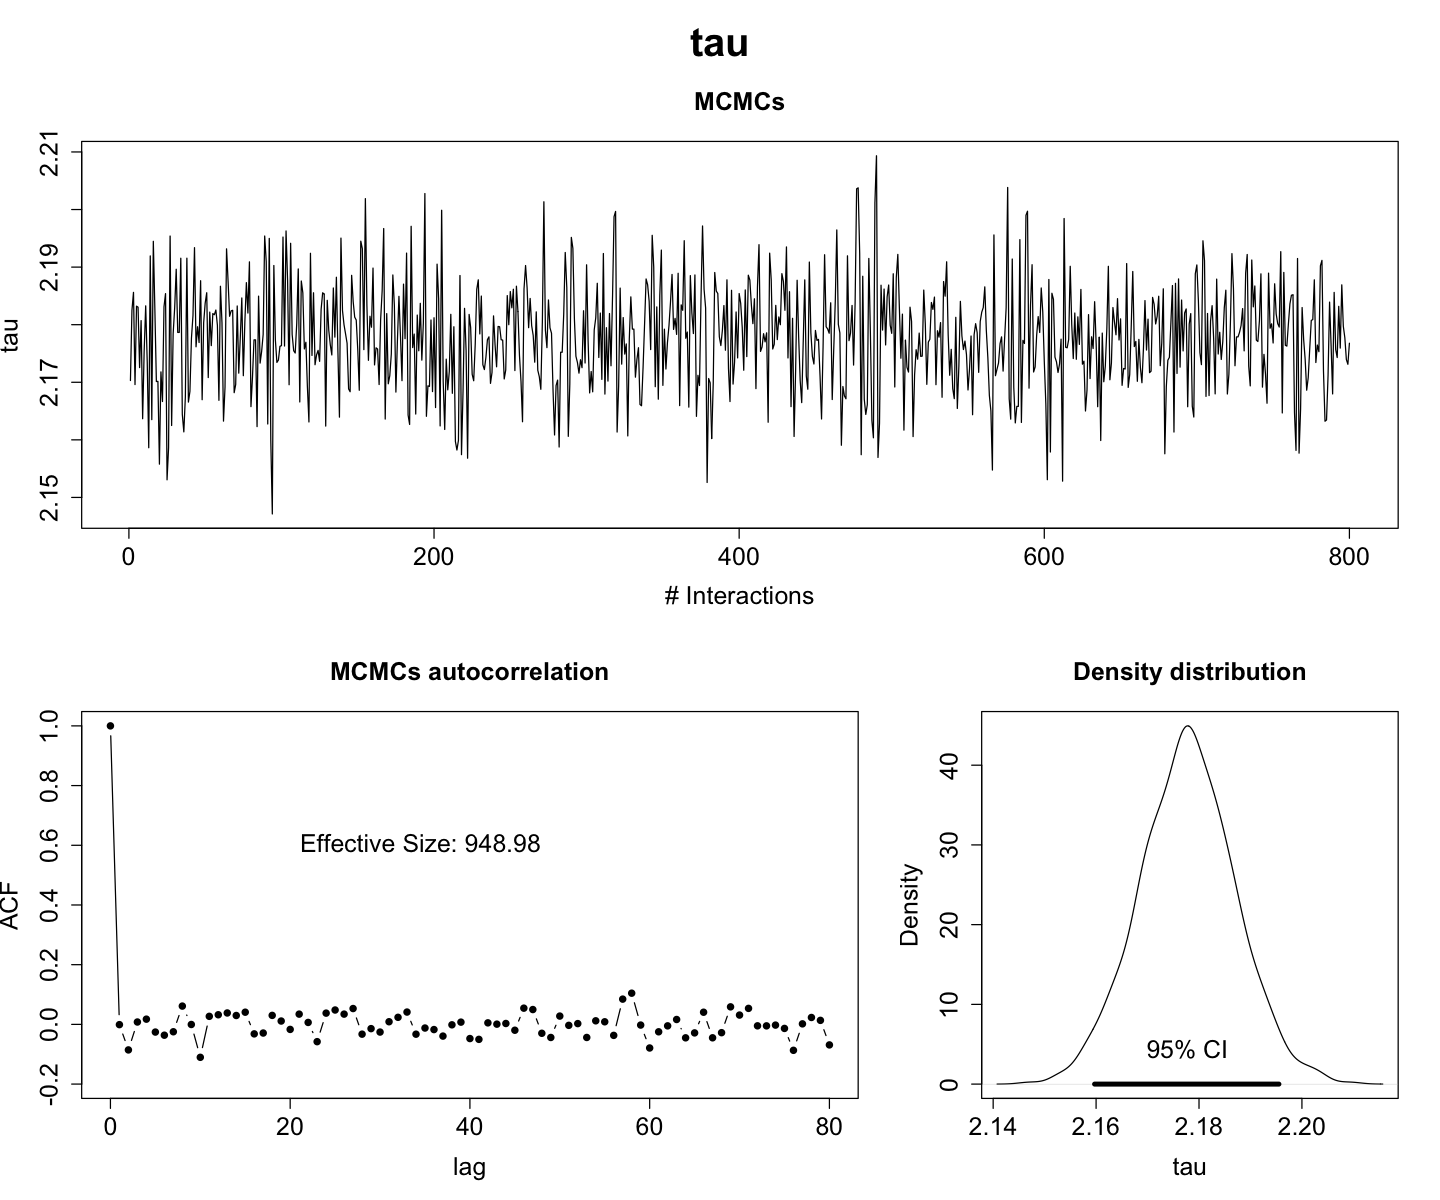

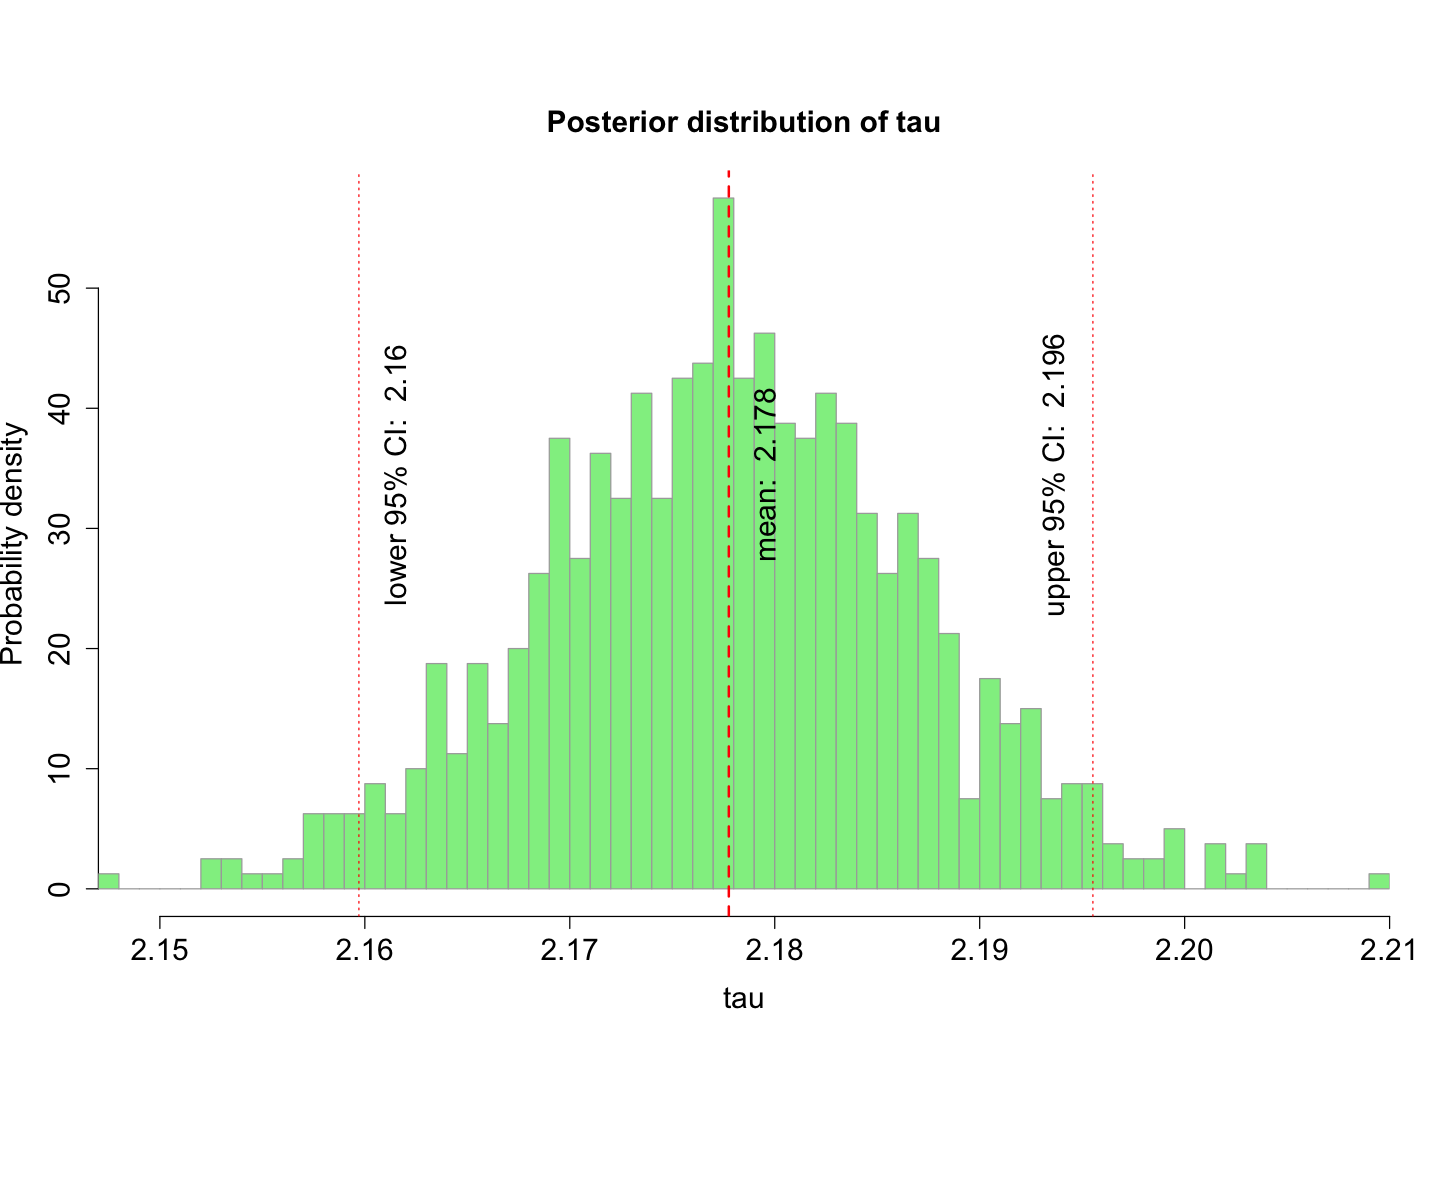

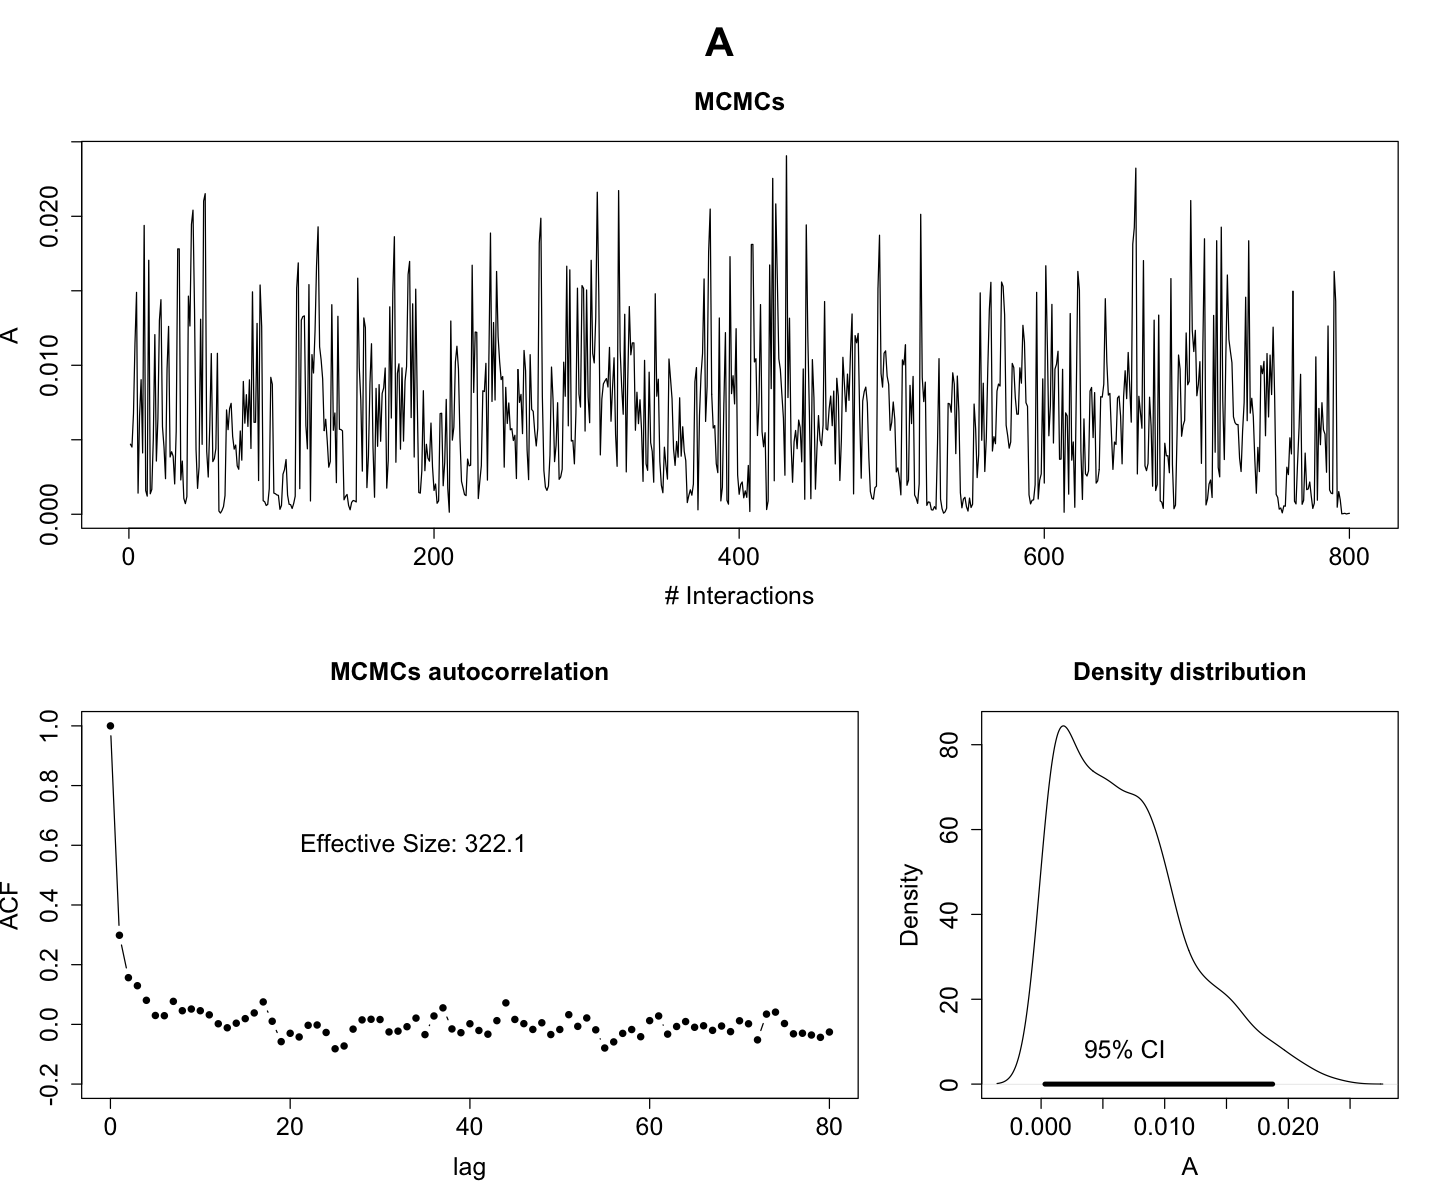

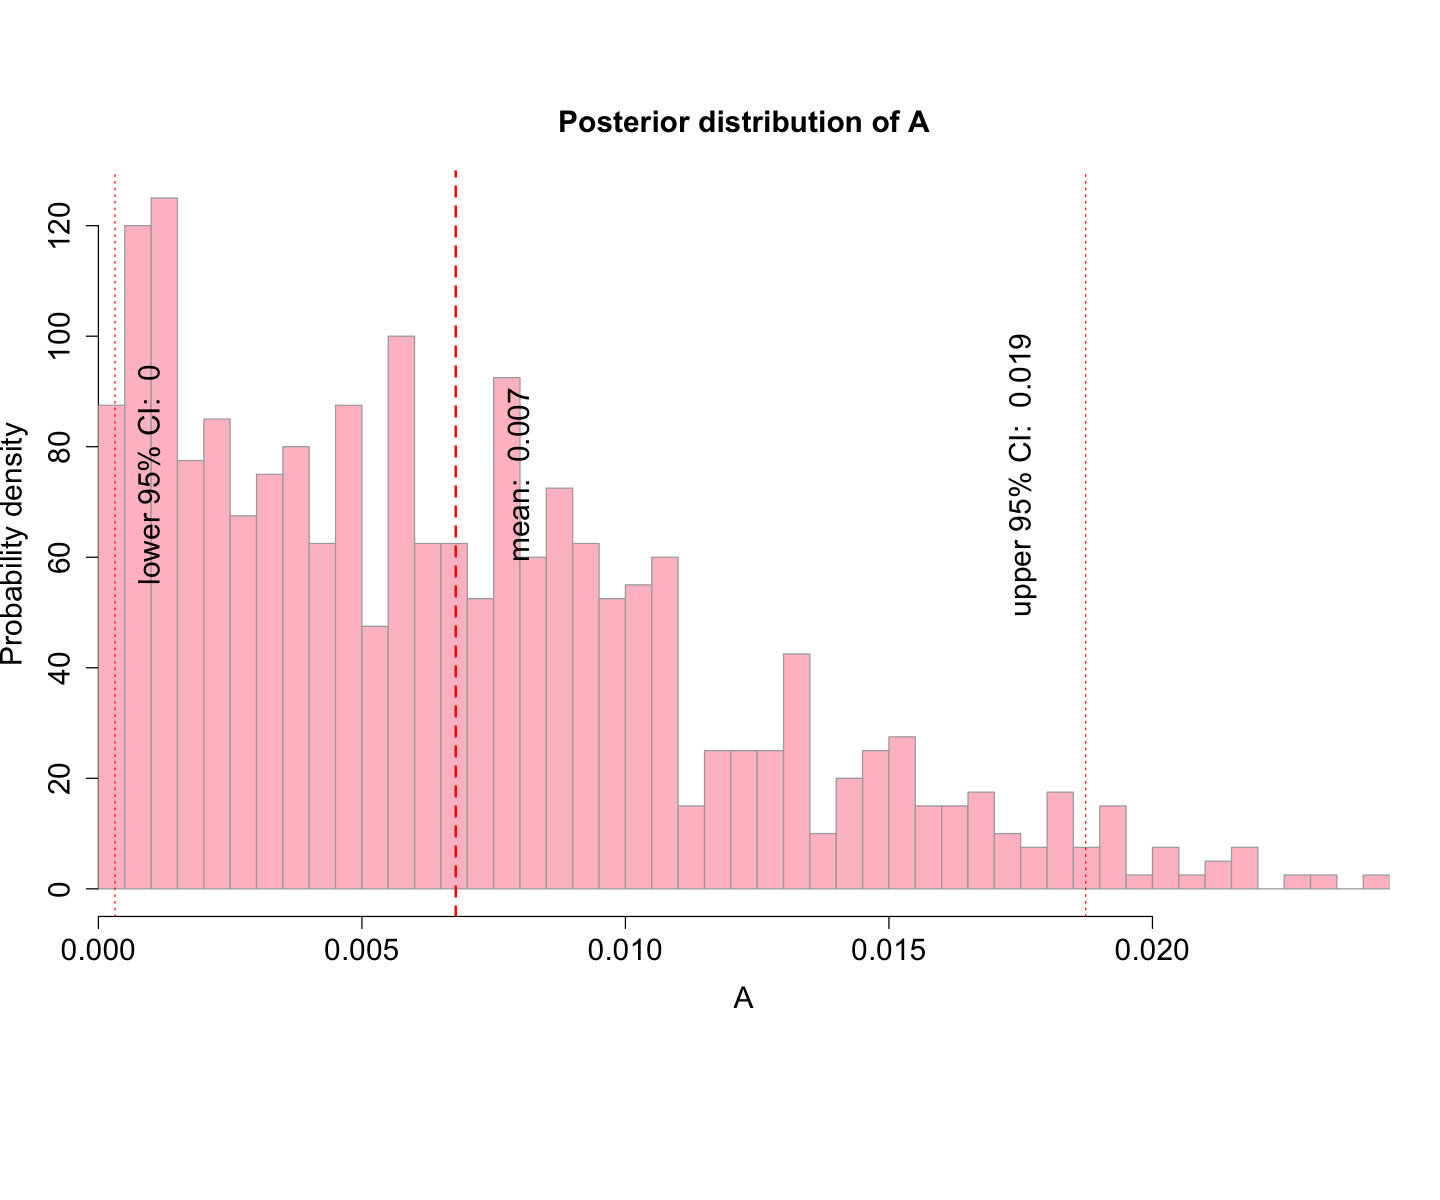

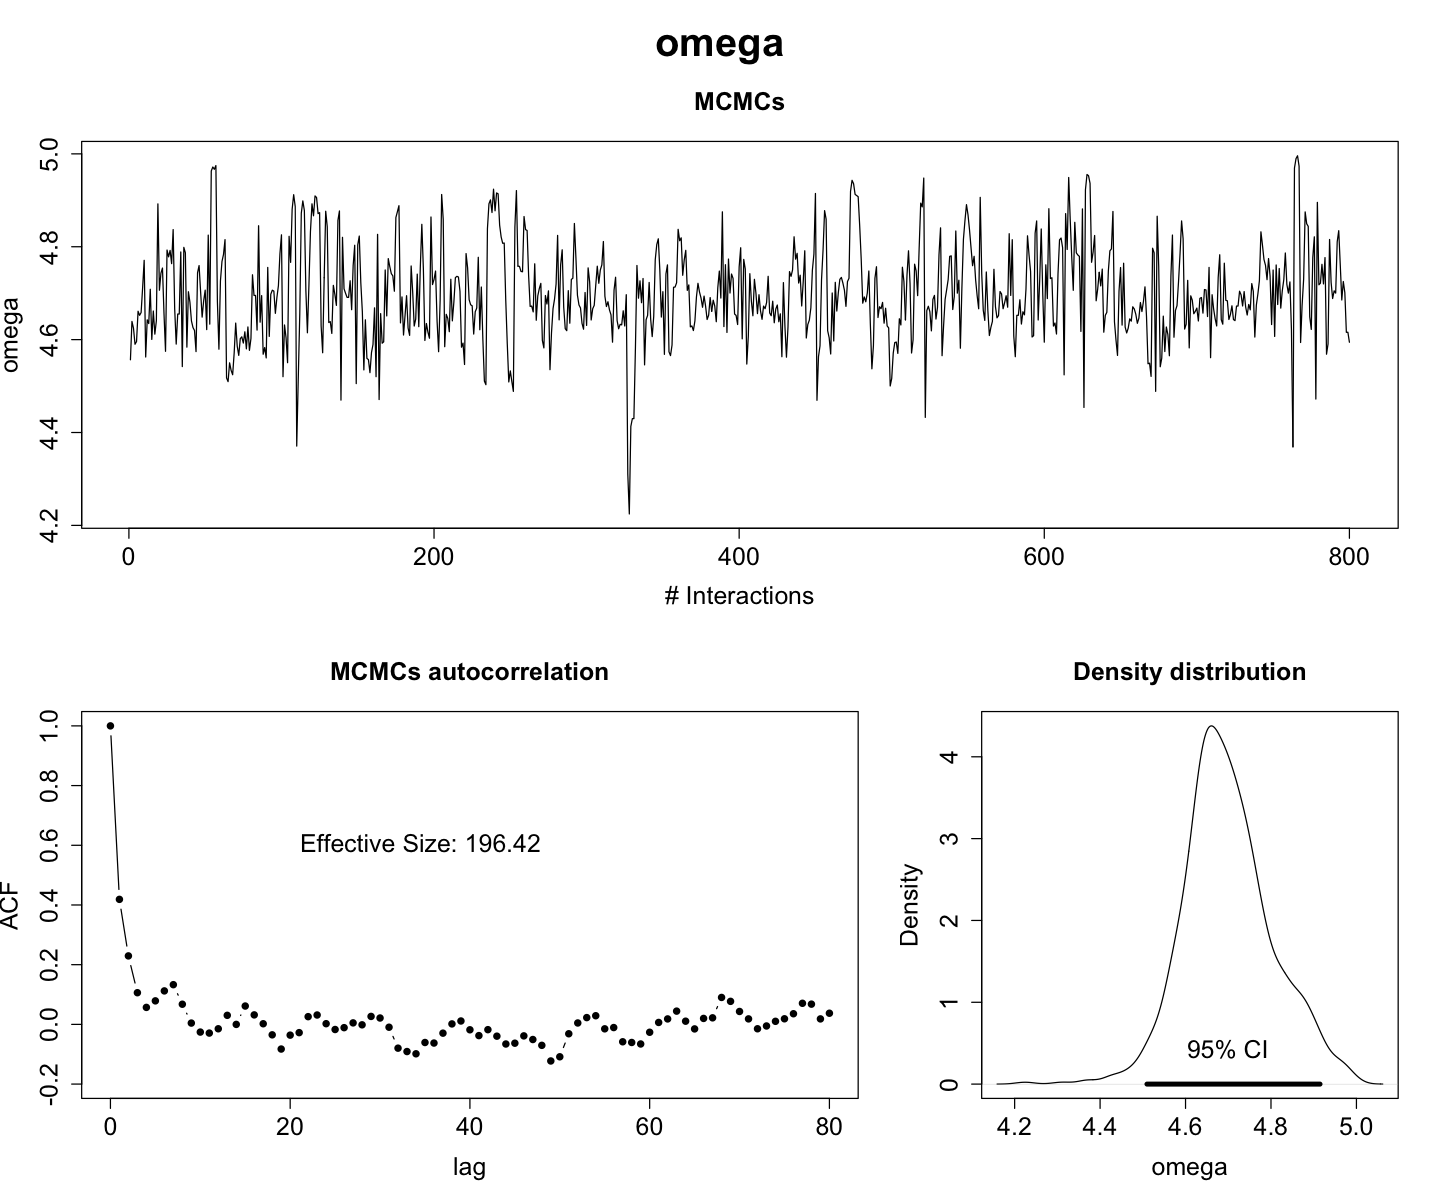

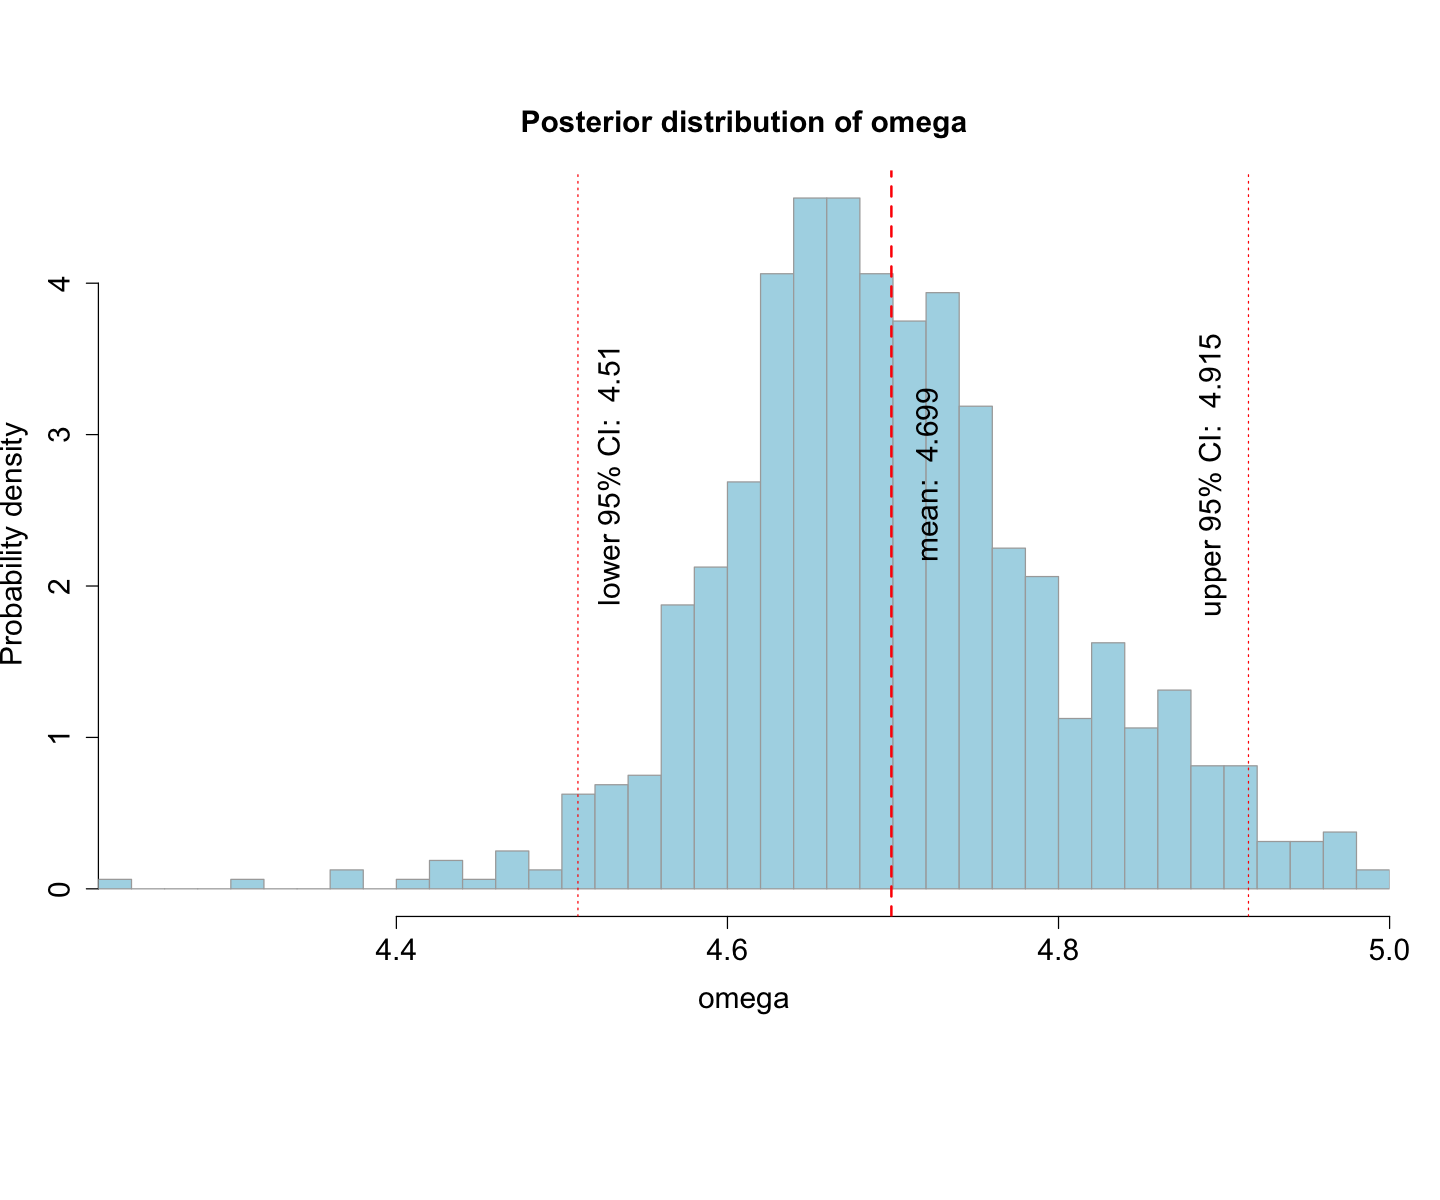

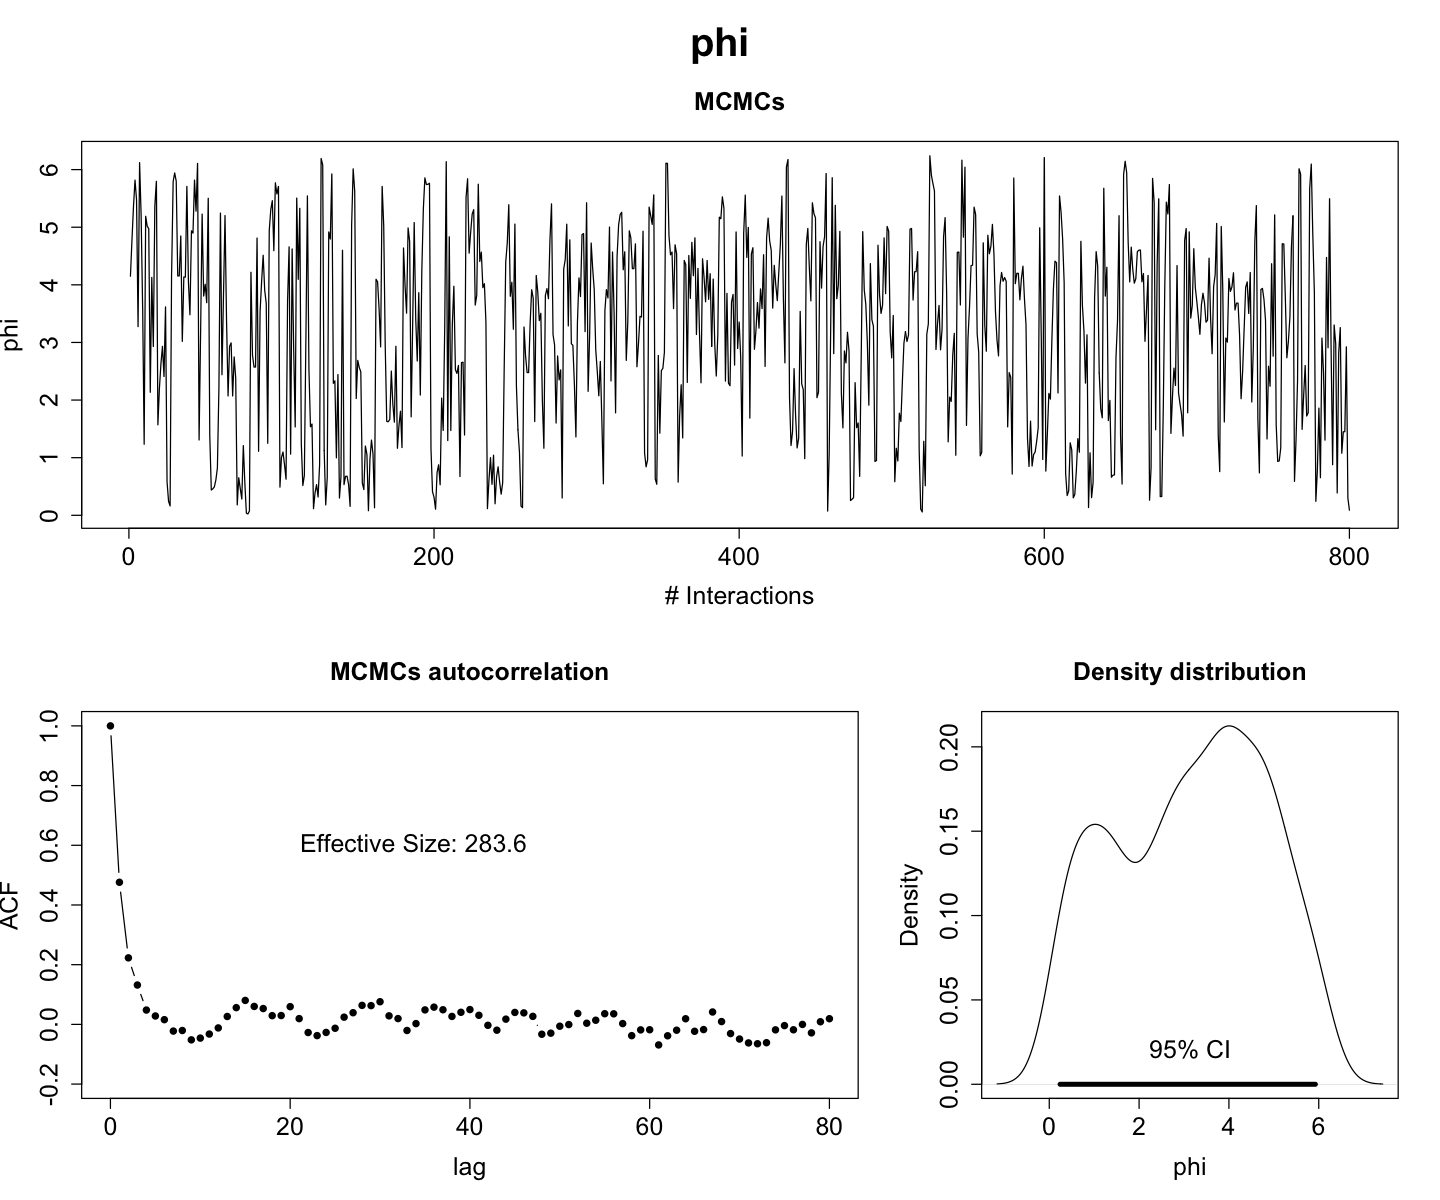

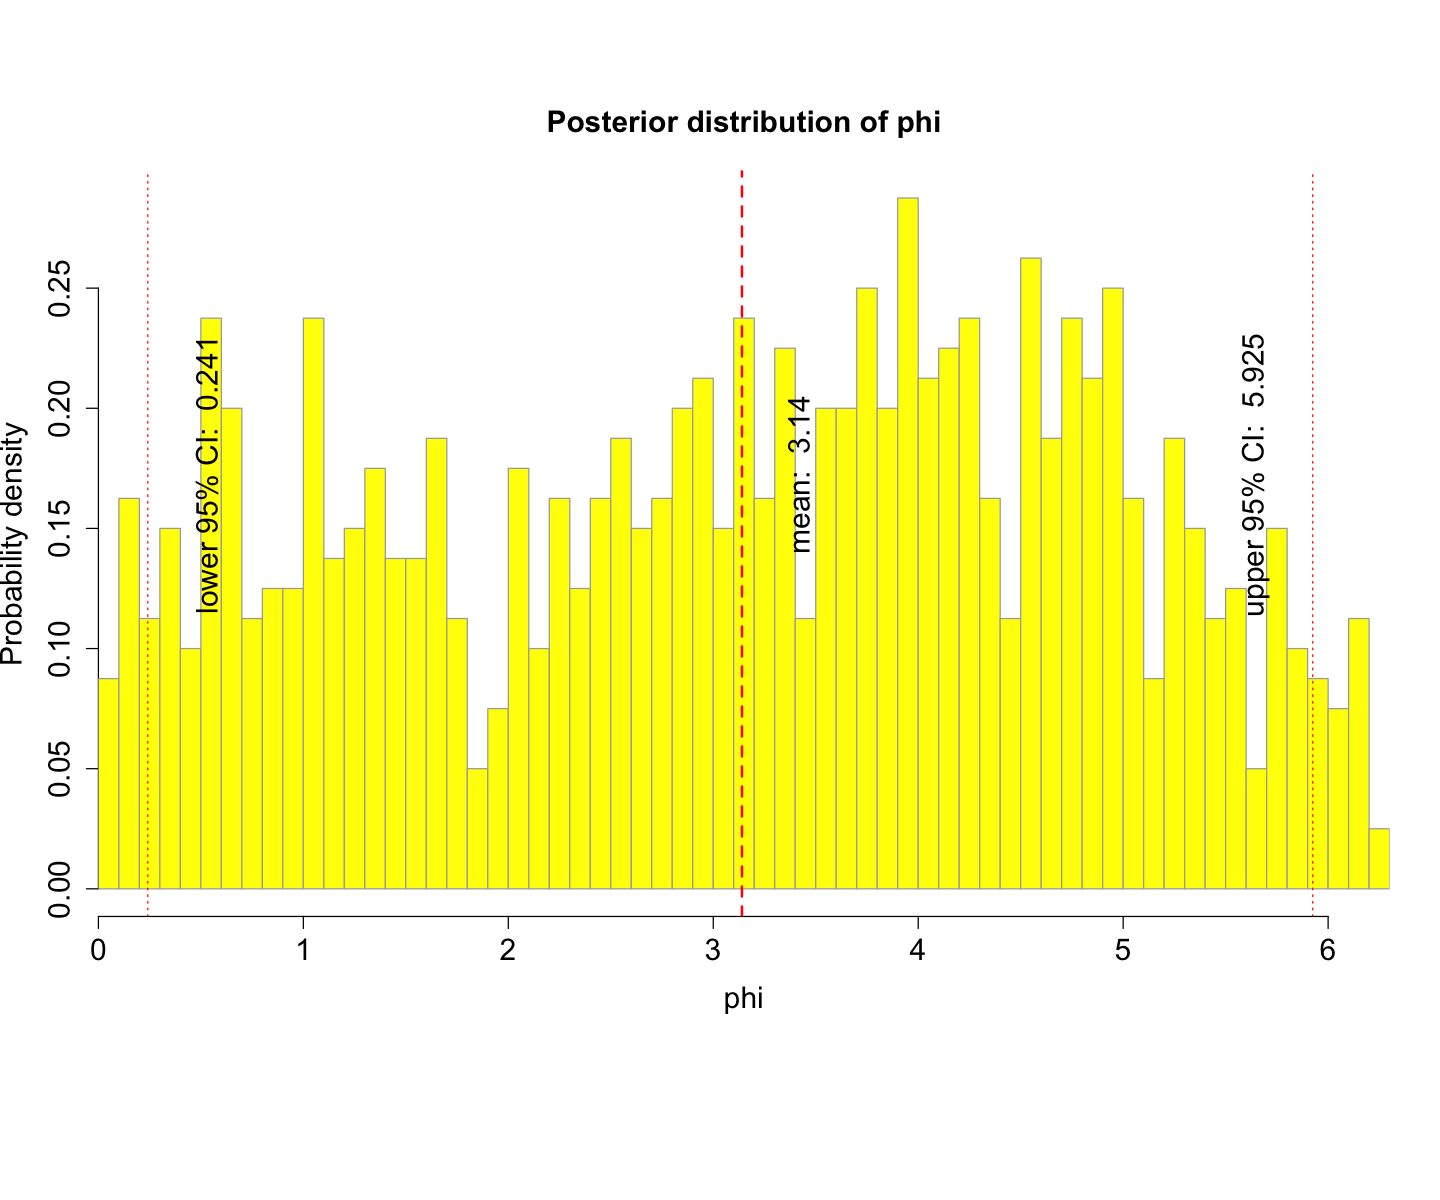

In [54]:
n.chains <- ncol(array.mcmc)
all.mcmc.coda <- mcmc.list( lapply (1:n.chains, function (x) { mcmc(array.mcmc[,x,]) })) # is a list of mcmc
params <- switch( which.model, c("N0","tau") , c("N0","tau","A","omega","phi") )
means <- numeric(length(params))

colors <- c("orange", "lightgreen", "pink", "lightblue", "yellow")

options(repr.plot.width=12, repr.plot.height=10)

# for cycle on all parameters
for(i in 1:length(params)) {

    par(mfrow=c(1, 1),oma=c(0,0,3,0))
    layout.matrix <- matrix(c(1, 2, 1, 3), nrow = 2, ncol = 2)
    layout(mat = layout.matrix,
       heights = c(1, 1), # Heights of the two rows
       widths = c(2.5, 1.5)) # Widths of the two columns
    
    # the chain interations
    for(j in 1:n.chains) {
        iteration.chain <- array.mcmc[,j,params[i]]
        max <- sapply( 1:n.chains, function(k) { max( array.mcmc[,k,params[i]] ) } ) |> max()
        min <- sapply( 1:n.chains, function(k) { min( array.mcmc[,k,params[i]] ) } ) |> min()
        
        if (j == 1) { plot( iteration.chain,type="l",col=j,cex.axis=1.5,cex.main=1.5,cex.lab=1.5,
                       main="MCMCs",ylab = params[i],xlab="# Interactions",ylim=c(min,max) ) }
        else {  lines(iteration.chain, col = j) }
    }
    
    mtext(params[i], outer=TRUE, cex=2, font=2)

    #autocorrelation
    my.lags <- 0:80
    for(j in 1:n.chains) {
        mcmc.coda <- all.mcmc.coda[[j]] # j-th chain
        acf <- autocorr(mcmc.coda[ ,params[i] ],lags=my.lags)
        if (j == 1) {
            plot(my.lags,acf,ylim=c(-0.2,1),type="b",pch=16,col=j,main="MCMCs autocorrelation",
            xlab="lag",ylab="ACF",cex.axis=1.5,cex.main=1.5,cex.lab=1.5)
        }
        else {
            lines(my.lags,acf,type="b", pch=16,col=j)
        }
    }
    text(20,0.6,paste( "Effective Size:",round(effectiveSize(mcmc.coda[,params[i]]),2)),pos=4,cex=1.5)

    all.data.param <- array.mcmc[,,params[i]]
    mean <- mean(all.data.param)
    means[i] <- mean
    CI <- quantile(all.data.param, c(0.025, 0.975))
    
    # density distribution
    for(j in 1:n.chains) {
        dens <- array.mcmc[,,params[i]]
        if (n.chains > 1){
            max <- sapply( 1:n.chains, function(k) { max(density(dens[,k])$y) } ) |> max()
            min <- sapply( 1:n.chains, function(k) { min(density(dens[,k])$y) } ) |> min()

            if (j == 1) { plot( density( dens[, j] ),main="Density distribution",
                           col=j,cex.axis=1.5,cex.main=1.5,cex.lab=1.5,xlab=params[i],
                           ylim=c(min,max) )
                            lines(c(CI[1],CI[2]),c(0,0),lwd=4)
                            text(mean, (max-min)*0.1, "95% CI",cex=1.5)
                        }   
            else { lines( density(dens[,j]),col=j ) }
        }
        else{
            max <- sapply( 1:n.chains, function(k) { max(density(dens)$y) } ) |> max()
            min <- sapply( 1:n.chains, function(k) { min(density(dens)$y) } ) |> min()

            plot( density( dens ),main="Density distribution",
                           col=j,cex.axis=1.5,cex.main=1.5,cex.lab=1.5,xlab=params[i],
                           ylim=c(min,max) )
                            lines(c(CI[1],CI[2]),c(0,0),lwd=4)
                            text(mean, (max-min)*0.1, "95% CI",cex=1.5)
            }
    }
  
    
    layout.matrix <- matrix(c(1,0), nrow=2, ncol=1)
    layout(mat = layout.matrix,
       heights = c(3,0.5),
       widths = c(2))
    
    # histrogram of distribution
    h <- hist(all.data.param, breaks=50, probability=TRUE, main=paste("Posterior distribution of", params[i]),
       xlab=params[i],ylab="Probability density",col=colors[i],border="darkgrey",xaxs="i",cex.axis=1.5,cex.main=1.5,cex.lab=1.5)    
    abline( v=mean, col="red", lwd=2, lty=2)

    h$density
    y_pos <- 0.6 * max(h$density)
    text(0.9*mean+0.1*CI[2],y_pos, paste("mean: ",round(mean,3)), srt=90,cex=1.5)
    
    # 95% CI
    abline(v=CI, col="red", lwd=1, lty=3)
    text(0.9*CI[1]+0.1*mean,y_pos,paste("lower 95% CI: ",round(CI[1],3)),cex=1.5,srt=90)
    text(0.9*CI[2]+0.1*mean,y_pos,paste("upper 95% CI: ",round(CI[2],3)),cex=1.5,srt=90)
}

In [ ]:
# combine sequentially all chains to get get one single dataframe for collelations
df <- lapply( params, function(p) { sapply(1:n.chains, function(j) array.mcmc[, j, p]) |> as.vector() } ) |> as.data.frame()
names(df) <- params
cat("Correlation matrix \n")
cor(df)

In [ ]:
options(repr.plot.width = 22, repr.plot.height = 22)

params <- names(df)
pairs <- combn(params, 2, simplify = FALSE)

n <- length(pairs)
ncol <- ceiling(sqrt(n))
nrow <- ceiling(n / ncol)

layout(matrix(1:(nrow * ncol), nrow = nrow, byrow = TRUE), widths = rep(1.2, ncol), heights = rep(1.2, nrow))
par(mar = c(5, 5, 2, 2), oma = c(2, 2, 2, 2))

for (p in pairs) {
  plot(df[[p[1]]], df[[p[2]]],
       xlab = p[1], ylab = p[2],
       main = paste(p[1], "vs", p[2]),
       cex.main = 2.5, cex.axis = 1.8, cex.lab = 1.8,
       pch = 16, col = "navy")
}

# STUDIO FREQUENTISTA

BOH DA FARE, SECONDO ME FIGO E GARFA SI ESALTA CON IL CONFRONTO

# COSA DA FARE

FRANCESCO:

Controllare codice (tutto anche generazione dati) già fatto. UNITA' DI MISURAAAAAA (microsecondi e omega freq boh non so in che unità di misura).
Mostrare una volta i risultati delle varie catene (uno solo esemplificativo)

MOSTRI GRAFICO VARIE POSTERIORI DI UN PARAMETRO PER STAN: Rifare tutto con prior dei parametri diverse (uniformi, jeffrey(beta(0.5,0.5)) in un range oppure normali informate)

Da rifare tutto con jags

MARCO:

Presentazione slides di teoria con apparato e due formule

Calcolo probabilità che il segnale sia due muoni attaccati arrivasti dall'universo e non mu+ --> e+ appena decaduto (perché per noi i segnali sono mu+ e+, da indagare tempi tipici di questo decadimento rispetto a tempi tipici di arrivo di un un muone)... Poissiana

omega ----> gu ??? propagazione degli errori, male male in advance statistics

ALTRO:

Confronto, quindi histogrammi su stesso plot di colore di verso delle posterior di tau e omega-oppure gu- (con prior la stessa) di STAN, JAGS, FREQUENTISTA 